In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import pickle

from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
)

sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../'))
from data import gather_signals_by_class
from exp_utils import (
    d_users_split, normalize_df_columns_0_1,
    display_roc_and_f1, display_conf_matrix,
    save_ml_model, load_ml_model
)


In [50]:
def get_df_from_csv(l_csv: list, num_features: int):
    # filtering csv files list by user id
    df = pd.DataFrame()

    for path in l_csv[:]:
        temp_df = pd.read_csv(path, delimiter=';', header=0)
        df = pd.concat([df, temp_df], ignore_index=True)    


    print(' >> Normalizando: [0,1]')
    df = normalize_df_columns_0_1(df)

    X = df.iloc[:, :63]  # Features (sensor data)
    y = df.iloc[:, 63]

    if num_features < 63:
        print(' >> Running PCA')
        pca = PCA(n_components=num_features)
        X = pca.fit_transform(X)

    df = pd.DataFrame(X, columns = [f'sensor_{i}' for i in range(num_features)])
    df['label'] = y.values  # Adding the labels back

    return df

def save_ml_model(ml_model, model_path):
    with open(model_path,'wb') as f:
        pickle.dump(ml_model,f)

def load_ml_model(model_path):
    with open(model_path,'rb') as f:
        model = pickle.load(f)
    return model


In [51]:
paths_csv = glob.glob('../zhang-wamsley-2019/data/CSV/*.csv')

num_features = 63
window_size = 40

# Training Preparation

In [52]:
paths_train = [path for path in paths_csv 
                       if any(user_id in path 
                              for user_id in d_users_split['train']+d_users_split['val'])]

len(paths_train)

241

In [53]:
df_train = get_df_from_csv(paths_train, num_features)
df_train

 >> Normalizando: [0,1]


,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_54,sensor_55,sensor_56,sensor_57,sensor_58,sensor_59,sensor_60,sensor_61,sensor_62,label
0,0.533583,0.446590,0.486596,0.607916,0.563299,0.600998,0.610615,0.542302,0.625835,0.368158,...,0.658139,0.646036,0.540362,0.591495,0.787419,0.512061,0.644143,0.601839,0.594903,1
1,0.533527,0.446633,0.489557,0.607884,0.563319,0.600984,0.610604,0.542278,0.625863,0.368147,...,0.658149,0.646043,0.540337,0.591493,0.787425,0.512061,0.644146,0.601781,0.594911,1
2,0.533465,0.446678,0.491765,0.607887,0.563379,0.601002,0.610636,0.542277,0.625935,0.368150,...,0.658161,0.646051,0.540311,0.591495,0.787431,0.512061,0.644152,0.601727,0.594921,1
3,0.533404,0.446727,0.492360,0.607935,0.563469,0.601057,0.610710,0.542305,0.626046,0.368166,...,0.658173,0.646058,0.540290,0.591501,0.787440,0.512061,0.644159,0.601683,0.594937,1
4,0.533349,0.446789,0.491621,0.608022,0.563580,0.601144,0.610814,0.542358,0.626177,0.368196,...,0.658186,0.646065,0.540274,0.591510,0.787448,0.512061,0.644166,0.601649,0.594958,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7054369,0.531787,0.448565,0.487289,0.606377,0.561131,0.599560,0.608268,0.541382,0.623856,0.368215,...,0.658175,0.646166,0.540518,0.591713,0.787330,0.512061,0.644279,0.600824,0.594598,1
7054370,0.531692,0.448464,0.487608,0.606349,0.561105,0.599527,0.608199,0.541419,0.623775,0.368215,...,0.658218,0.646256,0.540513,0.591705,0.787411,0.512061,0.644318,0.600933,0.594620,1
7054371,0.531621,0.448335,0.488096,0.606334,0.561095,0.599516,0.608153,0.541489,0.623712,0.368229,...,0.658263,0.646331,0.540527,0.591703,0.787484,0.512061,0.644361,0.601002,0.594597,1
7054372,0.531585,0.448207,0.488571,0.606336,0.561105,0.599533,0.608140,0.541585,0.623677,0.368258,...,0.658311,0.646387,0.540558,0.591710,0.787548,0.512061,0.644406,0.601037,0.594552,1


In [68]:
X_train = df_train.iloc[:, :num_features]  # Features (sensor data)
y_train = df_train.iloc[:, num_features]

In [69]:
X_train

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_53,sensor_54,sensor_55,sensor_56,sensor_57,sensor_58,sensor_59,sensor_60,sensor_61,sensor_62
88086,0.531235,0.447779,0.486342,0.607432,0.562823,0.600804,0.609918,0.542350,0.625369,0.369049,...,0.277274,0.657763,0.645401,0.540045,0.591215,0.786868,0.512061,0.643942,0.600876,0.593924
88087,0.531311,0.447884,0.486477,0.607256,0.562634,0.600703,0.609797,0.542303,0.625157,0.369001,...,0.277241,0.657755,0.645364,0.540024,0.591196,0.786830,0.512061,0.643946,0.600763,0.593856
88088,0.531367,0.447987,0.486492,0.606998,0.562362,0.600540,0.609604,0.542230,0.624855,0.368923,...,0.277193,0.657765,0.645357,0.539991,0.591176,0.786807,0.512061,0.643971,0.600644,0.593816
88089,0.531391,0.448088,0.486483,0.606684,0.562039,0.600337,0.609366,0.542144,0.624500,0.368829,...,0.277129,0.657790,0.645380,0.539950,0.591154,0.786796,0.512061,0.644016,0.600527,0.593808
88090,0.531371,0.448184,0.487013,0.606346,0.561702,0.600115,0.609108,0.542058,0.624132,0.368730,...,0.277051,0.657827,0.645428,0.539900,0.591127,0.786797,0.512061,0.644079,0.600424,0.593832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7054357,0.531843,0.448308,0.487916,0.605499,0.560357,0.598689,0.607415,0.541007,0.623234,0.367676,...,0.277088,0.657966,0.645519,0.539865,0.590919,0.786716,0.512061,0.644062,0.599671,0.593267
7054358,0.531859,0.448232,0.487483,0.605556,0.560431,0.598692,0.607500,0.541007,0.623303,0.367659,...,0.277151,0.657953,0.645498,0.539955,0.590971,0.786710,0.512061,0.644048,0.599741,0.593208
7054359,0.531899,0.448166,0.487306,0.605651,0.560539,0.598748,0.607626,0.541039,0.623408,0.367676,...,0.277230,0.657943,0.645480,0.540067,0.591047,0.786709,0.512061,0.644037,0.599799,0.593161
7054360,0.531958,0.448123,0.487470,0.605776,0.560674,0.598851,0.607785,0.541098,0.623538,0.367726,...,0.277323,0.657941,0.645470,0.540194,0.591147,0.786717,0.512061,0.644034,0.599848,0.593153


In [70]:
y_train

88086      0
88087      0
88088      0
88089      0
88090      0
          ..
7054357    1
7054358    1
7054359    1
7054360    1
7054361    1
Name: label, Length: 7054360, dtype: int64

### Flatten window size slots

In [57]:
df_train = gather_signals_by_class(df_train, num_signals=window_size)

data_train = df_train[[f'sensor_{i}' for i in range(num_features)]].values
data_train.shape

(7054360, 63)

In [58]:
# Flatten
data_reshaped_train = data_train.reshape(-1, window_size, data_train.shape[1])
data_reshaped_train = data_reshaped_train.reshape(data_reshaped_train.shape[0], -1)
data_reshaped_train.shape

(176359, 2520)

In [59]:
labels_train = df_train['label'].values[::window_size]
labels_train.shape

(176359,)

# Testing Preparation

In [60]:
paths_test = [path for path in paths_csv 
                       if any(user_id in path 
                              for user_id in d_users_split['test'])]

len(paths_test)

57

In [61]:
df_test = get_df_from_csv(paths_test, num_features)
df_test

 >> Normalizando: [0,1]


,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_54,sensor_55,sensor_56,sensor_57,sensor_58,sensor_59,sensor_60,sensor_61,sensor_62,label
0,0.467874,0.609880,0.520999,0.409888,0.478351,0.596834,0.612438,0.446520,0.613551,0.635325,...,0.524489,0.634616,0.619777,0.615699,0.615804,0.623199,0.525060,0.647231,0.608495,0
1,0.461983,0.610127,0.519722,0.408978,0.478248,0.596717,0.611898,0.446442,0.612759,0.634789,...,0.524025,0.634346,0.618869,0.614465,0.614729,0.622234,0.525060,0.646145,0.611902,0
2,0.457337,0.610157,0.518396,0.408154,0.478168,0.596600,0.611580,0.446344,0.612211,0.634304,...,0.523597,0.633990,0.617749,0.613461,0.613558,0.621062,0.525060,0.645141,0.614443,0
3,0.454870,0.610020,0.518385,0.407454,0.478115,0.596489,0.611454,0.446233,0.611921,0.633907,...,0.523282,0.633591,0.616528,0.612858,0.612366,0.619795,0.525060,0.644257,0.615482,0
4,0.454959,0.609807,0.519373,0.406879,0.478087,0.596385,0.611461,0.446122,0.611881,0.633636,...,0.523139,0.633179,0.615347,0.612766,0.611229,0.618582,0.525060,0.643483,0.614707,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668943,0.445589,0.633392,0.520527,0.406531,0.478005,0.597673,0.606777,0.449086,0.613010,0.644302,...,0.519179,0.632375,0.620144,0.605981,0.612990,0.623213,0.523568,0.634665,0.605707,1
1668944,0.444444,0.633503,0.520826,0.406587,0.477994,0.597755,0.606725,0.449303,0.612916,0.644442,...,0.519161,0.632375,0.620090,0.606040,0.612976,0.623213,0.523749,0.634226,0.605542,1
1668945,0.443433,0.633707,0.520978,0.406662,0.477986,0.597850,0.606673,0.449551,0.612838,0.644596,...,0.519143,0.632339,0.619997,0.606099,0.612962,0.623213,0.523975,0.633698,0.605336,1
1668946,0.442522,0.634001,0.521031,0.406728,0.477980,0.597933,0.606607,0.449786,0.612759,0.644721,...,0.519125,0.632289,0.619877,0.606152,0.612948,0.623213,0.524246,0.633096,0.605113,1


In [62]:
X_test = df_test.iloc[:, :num_features]  # Features (sensor data)
y_test = df_test.iloc[:, num_features]

In [63]:
X_test

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_53,sensor_54,sensor_55,sensor_56,sensor_57,sensor_58,sensor_59,sensor_60,sensor_61,sensor_62
0,0.467874,0.609880,0.520999,0.409888,0.478351,0.596834,0.612438,0.446520,0.613551,0.635325,...,0.624022,0.524489,0.634616,0.619777,0.615699,0.615804,0.623199,0.525060,0.647231,0.608495
1,0.461983,0.610127,0.519722,0.408978,0.478248,0.596717,0.611898,0.446442,0.612759,0.634789,...,0.622661,0.524025,0.634346,0.618869,0.614465,0.614729,0.622234,0.525060,0.646145,0.611902
2,0.457337,0.610157,0.518396,0.408154,0.478168,0.596600,0.611580,0.446344,0.612211,0.634304,...,0.621563,0.523597,0.633990,0.617749,0.613461,0.613558,0.621062,0.525060,0.645141,0.614443
3,0.454870,0.610020,0.518385,0.407454,0.478115,0.596489,0.611454,0.446233,0.611921,0.633907,...,0.620982,0.523282,0.633591,0.616528,0.612858,0.612366,0.619795,0.525060,0.644257,0.615482
4,0.454959,0.609807,0.519373,0.406879,0.478087,0.596385,0.611461,0.446122,0.611881,0.633636,...,0.621058,0.523139,0.633179,0.615347,0.612766,0.611229,0.618582,0.525060,0.643483,0.614707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668943,0.445589,0.633392,0.520527,0.406531,0.478005,0.597673,0.606777,0.449086,0.613010,0.644302,...,0.628325,0.519179,0.632375,0.620144,0.605981,0.612990,0.623213,0.523568,0.634665,0.605707
1668944,0.444444,0.633503,0.520826,0.406587,0.477994,0.597755,0.606725,0.449303,0.612916,0.644442,...,0.628332,0.519161,0.632375,0.620090,0.606040,0.612976,0.623213,0.523749,0.634226,0.605542
1668945,0.443433,0.633707,0.520978,0.406662,0.477986,0.597850,0.606673,0.449551,0.612838,0.644596,...,0.628332,0.519143,0.632339,0.619997,0.606099,0.612962,0.623213,0.523975,0.633698,0.605336
1668946,0.442522,0.634001,0.521031,0.406728,0.477980,0.597933,0.606607,0.449786,0.612759,0.644721,...,0.628339,0.519125,0.632289,0.619877,0.606152,0.612948,0.623213,0.524246,0.633096,0.605113


In [64]:
y_test

0          0
1          0
2          0
3          0
4          0
          ..
1668943    1
1668944    1
1668945    1
1668946    1
1668947    1
Name: label, Length: 1668948, dtype: int64

### Flatten window size slots

In [65]:
df_test = gather_signals_by_class(df_test, num_signals=window_size)

data_test = df_test[[f'sensor_{i}' for i in range(num_features)]].values
data_test.shape

(1668880, 63)

In [66]:
# Flatten
data_reshaped_test = data_test.reshape(-1, window_size, data_test.shape[1])
data_reshaped_test = data_reshaped_test.reshape(data_reshaped_test.shape[0], -1)
data_reshaped_test.shape

(41722, 2520)

In [67]:
labels_test = df_test['label'].values[::window_size]
labels_test.shape

(41722,)

# SVM - Support Vector Machine

In [ ]:
model_path = '..\models\ml_models\svm\.pkl'

if os.path.exists(model_path):
    print(' >> Loading model')
    clf = load_ml_model(model_path)

In [71]:
clf = svm.SVC(
    kernel='rbf',
    C=1.0
)

clf.fit(data_reshaped_train, labels_train)

KeyboardInterrupt: 

In [ ]:
# Save model
save_ml_model(clf, '../models/ml_models/svm.pkl')

In [ ]:
y_pred_train_svm = clf.predict(data_reshaped_train)
y_pred_train_svm

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
y_pred_test_svm = clf.predict(data_reshaped_test)
y_pred_test_svm

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

 >> Displaying Training Metrics
F1 Score: 0.7167787092646336


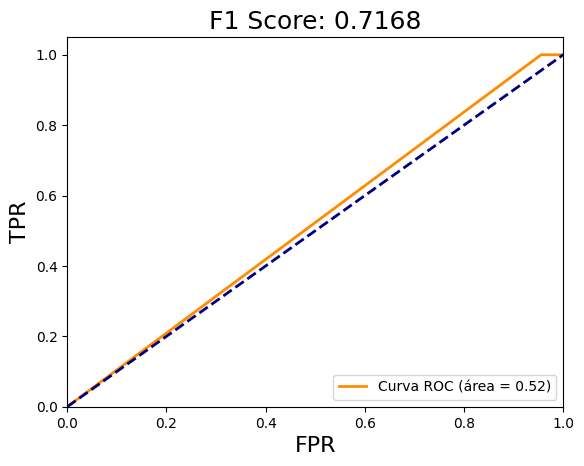

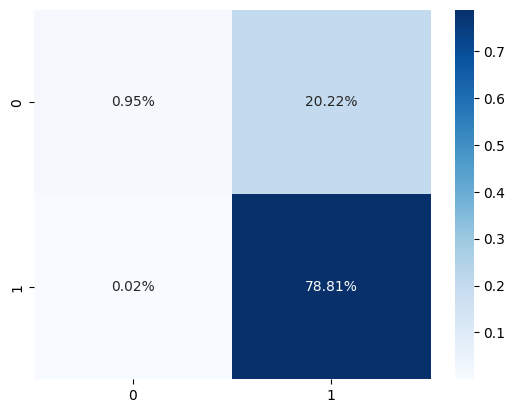

In [ ]:
# Show train metrics
print(' >> Displaying Training Metrics')
display_roc_and_f1(labels_train, y_pred_train_svm)
display_conf_matrix(labels_train, y_pred_train_svm)

Displaying Testing Metrics
F1 Score: 0.6227723132167234


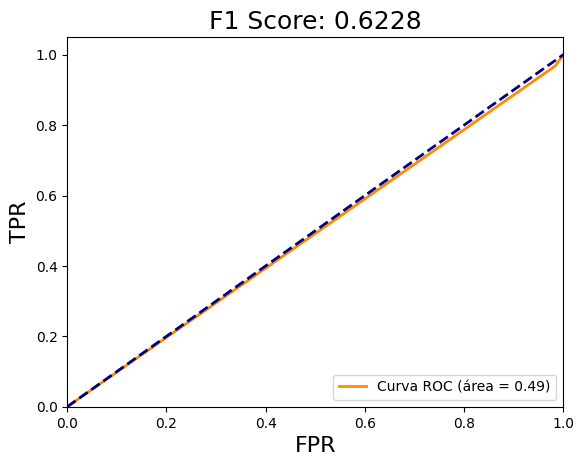

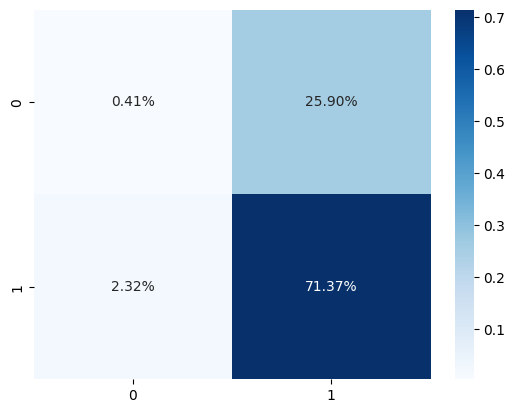

In [ ]:
# Show test metrics
print('Displaying Testing Metrics')
display_roc_and_f1(labels_test, y_pred_test_svm)
display_conf_matrix(labels_test, y_pred_test_svm)

# Logistic Regresion

In [ ]:
model_path = '..\models\ml_models\logic_reg\logic_regre_pca.pkl'

if os.path.exists(model_path):
    print(' >> Loading model')
    lr_model = load_ml_model(model_path)

In [72]:
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=10000,
    n_jobs = -1,
    random_state=11
)

lr_model.fit(data_reshaped_train, labels_train)

LogisticRegression(class_weight='balanced', max_iter=10000, n_jobs=-1,
                   random_state=11)

In [73]:
# Save model
save_ml_model(lr_model, '../models/ml_models/logic_regre.pkl')

In [74]:
y_pred_train_lr = lr_model.predict(data_reshaped_train)
y_pred_train_lr

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [75]:
y_pred_test_lr = lr_model.predict(data_reshaped_test)
y_pred_test_lr

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

 >> Displaying Training Metrics
F1 Score: 0.5675055165418663


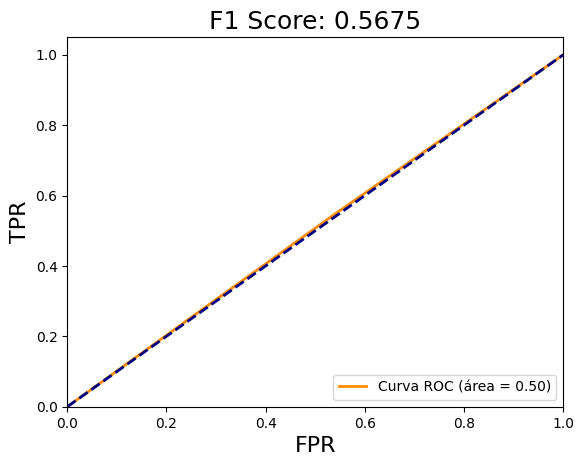

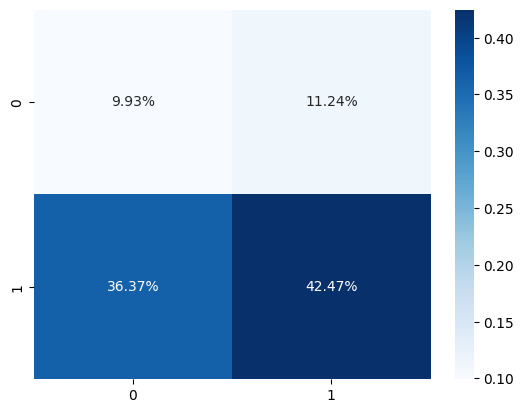

In [76]:
# Show train metrics
print(' >> Displaying Training Metrics')
display_roc_and_f1(labels_train, y_pred_train_lr)
display_conf_matrix(labels_train, y_pred_train_lr)

Displaying Testing Metrics
F1 Score: 0.6246638714004732


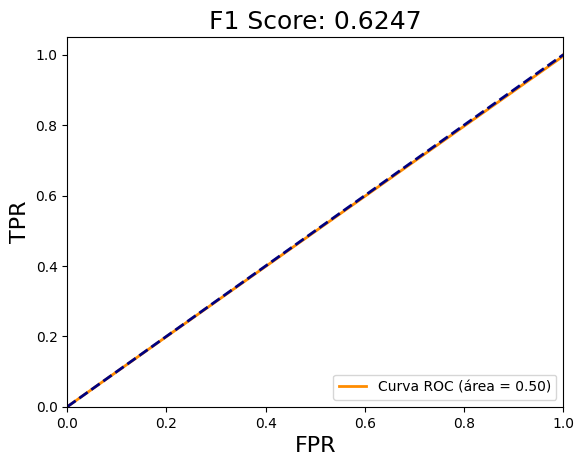

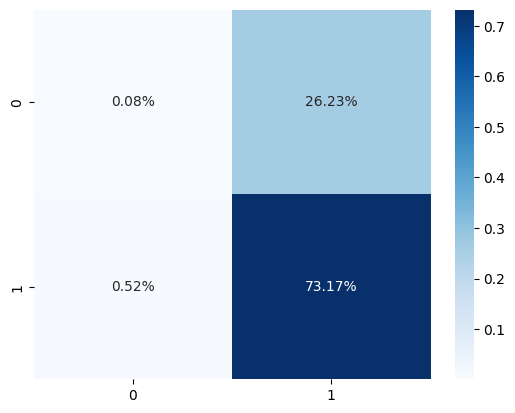

In [77]:
# Show test metrics
print('Displaying Testing Metrics')
display_roc_and_f1(labels_test, y_pred_test_lr)
display_conf_matrix(labels_test, y_pred_test_lr)

# SGD - Stochastic Gradient Descent

In [78]:
model_path = '..\models\ml_models\stochastic\sgd_pca.pkl'

if os.path.exists(model_path):
    print(' >> Loading model')
    sgd_clf = load_ml_model(model_path)

 >> Loading model


In [79]:
sgd_clf = SGDClassifier(
    loss='log_loss',
    max_iter=100000,
    tol=1e-3,
    random_state=42
)

sgd_clf.fit(data_reshaped_train, labels_train)

SGDClassifier(loss='log_loss', max_iter=100000, random_state=42)

In [80]:
# Save model
save_ml_model(sgd_clf, '../models/ml_models/sgd.pkl')

In [81]:
y_pred_train_sgd = sgd_clf.predict(data_reshaped_train)
y_pred_train_sgd

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [82]:
y_pred_test_sgd = sgd_clf.predict(data_reshaped_test)
y_pred_test_sgd

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

 >> Displaying Training Metrics
F1 Score: 0.695034662340195


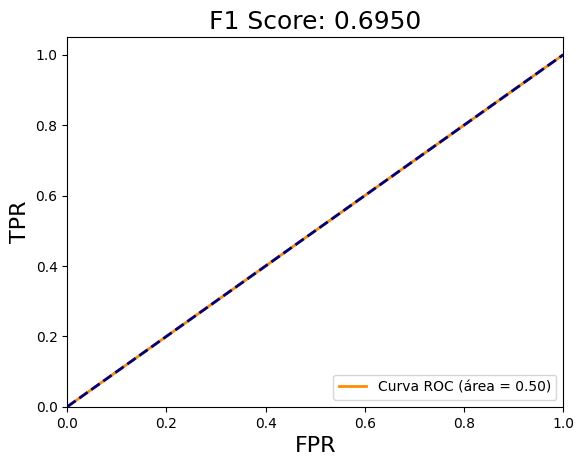

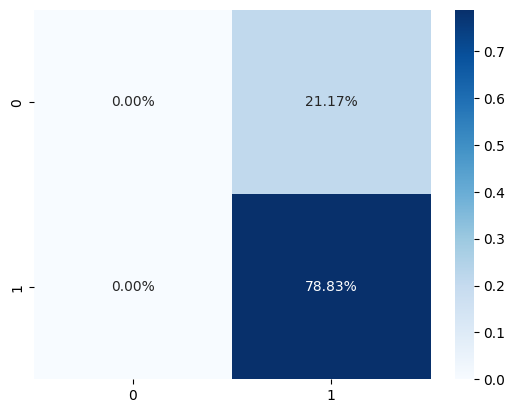

In [83]:
# Show train metrics
print(' >> Displaying Training Metrics')
display_roc_and_f1(labels_train, y_pred_train_sgd)
display_conf_matrix(labels_train, y_pred_train_sgd)

Displaying Testing Metrics
F1 Score: 0.6252465876090707


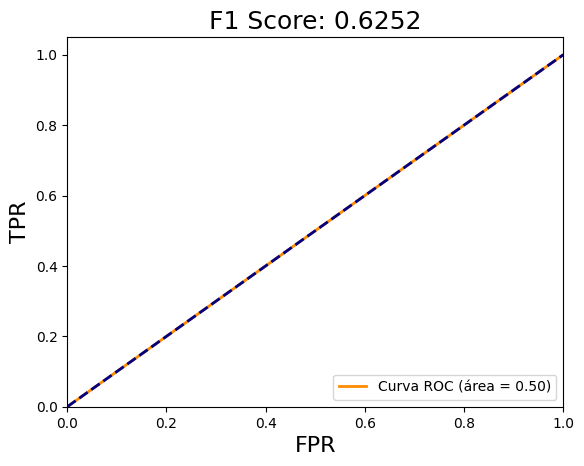

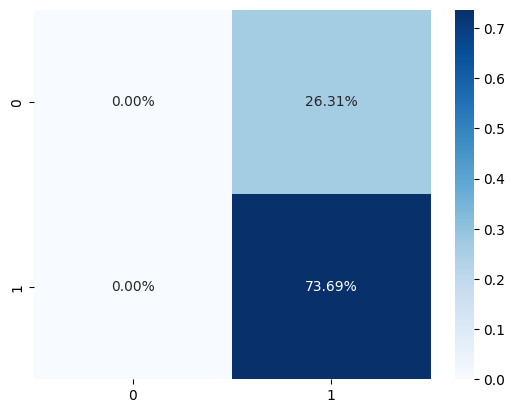

In [84]:
# Show test metrics
print('Displaying Testing Metrics')
display_roc_and_f1(labels_test, y_pred_test_sgd)
display_conf_matrix(labels_test, y_pred_test_sgd)

# Decision Tree

In [85]:
model_path = '..\models\ml_models\decision_tree\dtc_g_pca.pkl'

if os.path.exists(model_path):
    print(' >> Loading model')
    dtc_g = load_ml_model(model_path)

 >> Loading model


In [86]:
dtc_g = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=1,
    max_depth=20
)

dtc_g.fit(data_reshaped_train, labels_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=20, random_state=1)

In [87]:
# Save model
save_ml_model(dtc_g, '../models/ml_models/dtc_g.pkl')

In [88]:
y_pred_train_dt = dtc_g.predict(data_reshaped_train)
y_pred_train_dt

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [89]:
y_pred_test_dt = dtc_g.predict(data_reshaped_test)
y_pred_test_dt

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

 >> Displaying Training Metrics
F1 Score: 0.8729590439632927


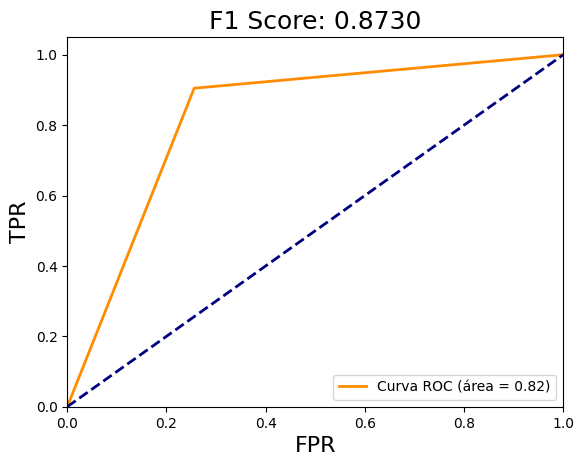

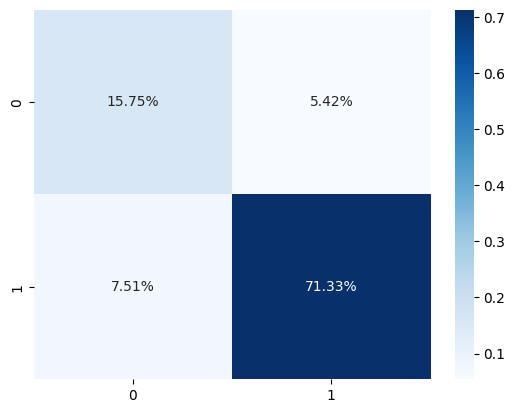

In [90]:
# Show train metrics
print(' >> Displaying Training Metrics')
display_roc_and_f1(labels_train, y_pred_train_dt)
display_conf_matrix(labels_train, y_pred_train_dt)

Displaying Testing Metrics
F1 Score: 0.11535462890255167


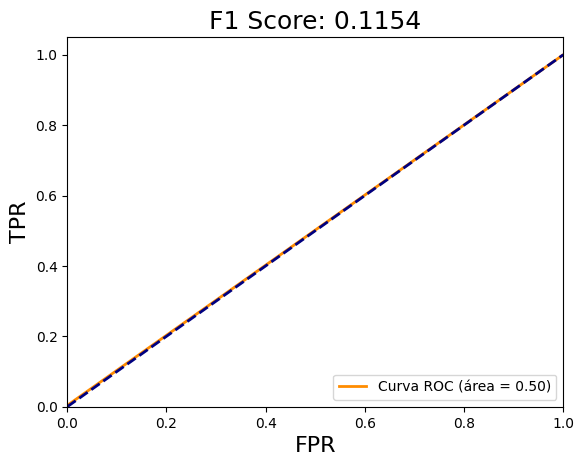

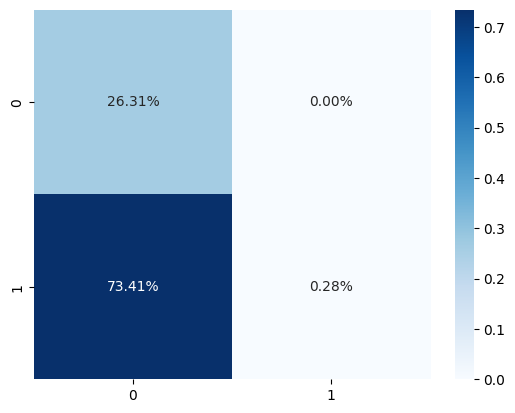

In [91]:
# Show test metrics
print('Displaying Testing Metrics')
display_roc_and_f1(labels_test, y_pred_test_dt)
display_conf_matrix(labels_test, y_pred_test_dt)

# Random Forest

In [92]:
model_path = '..\models\ml_models\random_forest\rdf_pca.pkl'

if os.path.exists(model_path):
    print(' >> Loading model')
    rdf = load_ml_model(model_path)

In [93]:
rdf = RandomForestClassifier(
    random_state=1,
    n_estimators=400,
    class_weight='balanced',
    max_depth=20,
)

rdf.fit(data_reshaped_train, labels_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=400,
                       random_state=1)

In [94]:
# Save model
save_ml_model(rdf, '../models/ml_models/rdf.pkl')

In [95]:
y_pred_train_rdf = rdf.predict(data_reshaped_train)
y_pred_train_rdf

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [96]:
y_pred_test_rdf = rdf.predict(data_reshaped_test)
y_pred_test_rdf

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

 >> Displaying Training Metrics
F1 Score: 0.9353420957041458


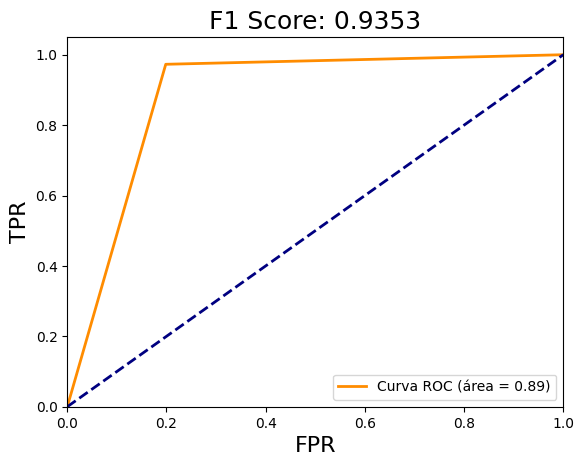

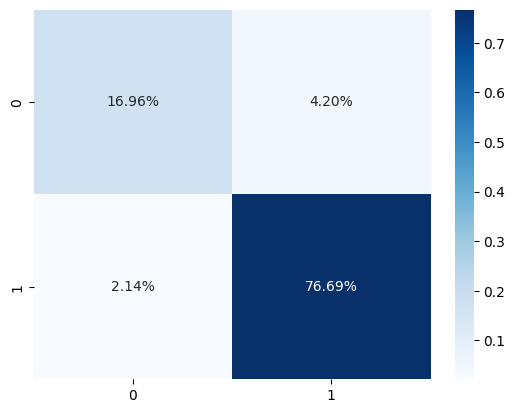

In [97]:
# Show train metrics
print(' >> Displaying Training Metrics')
display_roc_and_f1(labels_train, y_pred_train_rdf)
display_conf_matrix(labels_train, y_pred_train_rdf)

Displaying Testing Metrics
F1 Score: 0.6252465876090707


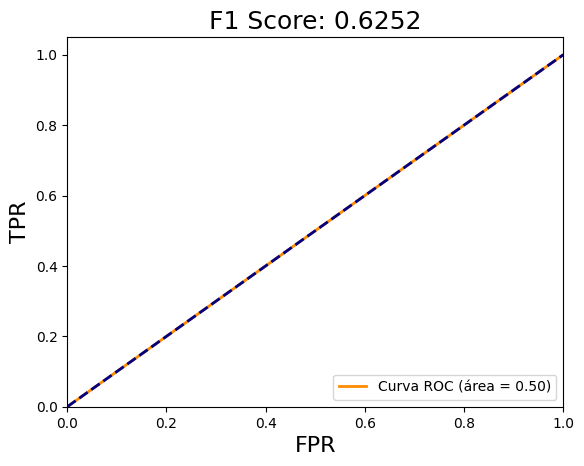

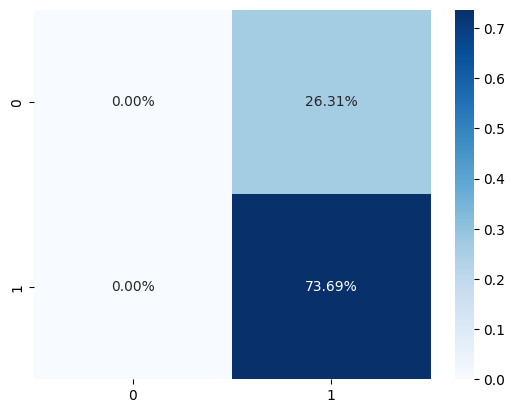

In [98]:
# Show test metrics
print('Displaying Testing Metrics')
display_roc_and_f1(labels_test, y_pred_test_rdf)
display_conf_matrix(labels_test, y_pred_test_rdf)

# Ada Boost

In [99]:
model_path = '..\models\ml_models\adaBoost\ada.pkl'

if os.path.exists(model_path):
    print(' >> Loading model')
    ada = load_ml_model(model_path)

In [100]:
ada = AdaBoostClassifier(
    n_estimators=100,
    random_state=42
)

ada.fit(data_reshaped_train, labels_train)

In [ ]:
# Save model
save_ml_model(ada, '../models/ml_models/ada.pkl')

In [ ]:
y_pred_train_ada = ada.predict(data_reshaped_train)
y_pred_train_ada

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
y_pred_test_ada = ada.predict(data_reshaped_test)
y_pred_test_ada

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

 >> Displaying Training Metrics
F1 Score: 0.7454432420302274


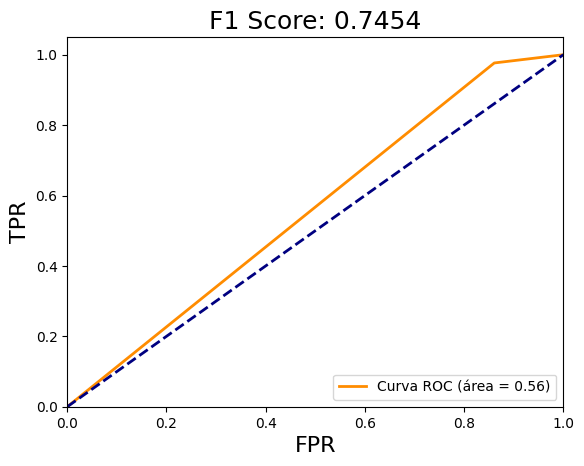

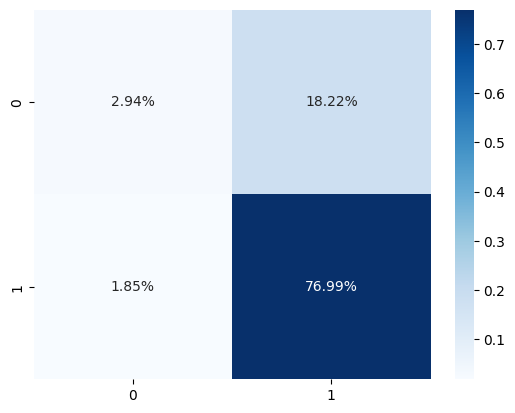

In [ ]:
# Show train metrics
print(' >> Displaying Training Metrics')
display_roc_and_f1(labels_train, y_pred_train_ada)
display_conf_matrix(labels_train, y_pred_train_ada)

Displaying Testing Metrics
F1 Score: 0.6492267248593508


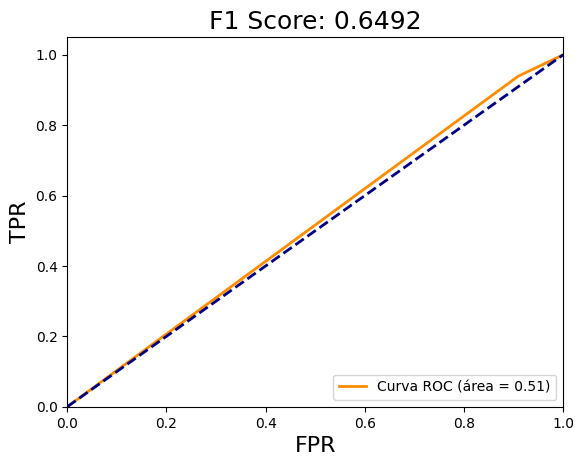

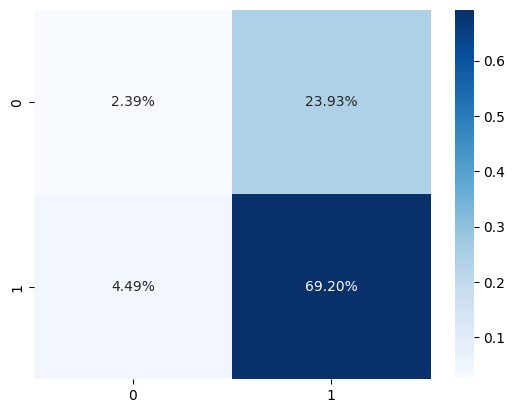

In [ ]:
# Show test metrics
print('Displaying Testing Metrics')
display_roc_and_f1(labels_test, y_pred_test_ada)
display_conf_matrix(labels_test, y_pred_test_ada)